In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa

In [2]:
# Path to train images
train_dir = '../input/plant-seedlings-classification/train/'
train_dir_seg = '../input/plant-seedling-segmented/plant-seedling-segmented/seg_train/'
train_dir_large = '../input/plant-seedling-large/plant-seedlings-large/train-large/'
train_dir_seg_large = '../input/plant-seedling-large/plant-seedlings-large/train-large-seg/'


# Path to test images
test_dir = '../input/plant-seedlings-classification/'
test_dir_seg = '../input/plant-seedling-segmented/plant-seedling-segmented/'

model_dir = '../input/plant-seedling-models/'

In [3]:
train = train_dir_large
test = test_dir

In [4]:
phase = 'train'

nb_epoch     = 100
batch_size   = 16
width        = 299
height       = 299

In [5]:
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                 "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

binary_list = ["Black-grass", "Loose Silky-bent"]

In [6]:
def Create_Directory_DataFrame(basedir, basedir_seg):
    df = pd.DataFrame(columns=['Class','Location'])
    # basedir
    for Class in os.listdir(basedir+'/'):
        for location in os.listdir(basedir+'/'+Class+'/'):
            df = df.append({'Class':Class,'Location':basedir+'/'+Class+'/'+location, 'Location_seg':basedir_seg+'/'+Class+'/'+location},ignore_index=True)
    return df

In [7]:
df = Create_Directory_DataFrame(train_dir_large, train_dir_seg_large)
print(df['Class'].unique())

['Scentless Mayweed' 'Common wheat' 'Charlock' 'Black-grass' 'Sugar beet'
 'Loose Silky-bent' 'Maize' 'Cleavers' 'Common Chickweed' 'Fat Hen'
 'Small-flowered Cranesbill' 'Shepherds Purse']


In [8]:
binary_df = df[(df['Class']=='Black-grass') | (df['Class']=='Loose Silky-bent')]
print(binary_df['Class'].unique())

['Black-grass' 'Loose Silky-bent']


In [9]:
binary_df.head()

,Class,Location,Location_seg
3000,Black-grass,../input/plant-seedling-large/plant-seedlings-...,../input/plant-seedling-large/plant-seedlings-...
3001,Black-grass,../input/plant-seedling-large/plant-seedlings-...,../input/plant-seedling-large/plant-seedlings-...
3002,Black-grass,../input/plant-seedling-large/plant-seedlings-...,../input/plant-seedling-large/plant-seedlings-...
3003,Black-grass,../input/plant-seedling-large/plant-seedlings-...,../input/plant-seedling-large/plant-seedlings-...
3004,Black-grass,../input/plant-seedling-large/plant-seedlings-...,../input/plant-seedling-large/plant-seedlings-...


In [10]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(binary_df, test_size=0.1)

In [11]:
def define_generators():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
        validation_split=0.1,
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True
    )
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe = train_df,
        x_col="Location",
        y_col="Class",
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="binary",
        shuffle=True
    )

    validation_generator = train_datagen.flow_from_dataframe(
        dataframe = val_df,
        x_col="Location",
        y_col="Class",
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="binary",
        shuffle=False
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
    )

    test_generator = test_datagen.flow_from_directory(
        directory=test_dir_seg,
        classes=['test'],
        target_size=(width, height),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='binary')


    return train_generator, validation_generator, test_generator

In [12]:
# define appropriate callbacks
def training_callbacks():
    
    # save best model regularly
    save_best_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.h5',
        monitor = 'accuracy', save_best_only = True, verbose = 1)
    
    # reduce learning rate when it stops decreasing
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                              patience = 3, min_lr = 1e-10, verbose = 1, cooldown = 1)
    
    # stop training early if no further improvement
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss', min_delta = 1e-2, patience = 30, verbose = 1,
        mode = 'min', baseline = None, restore_best_weights = True
    )

    return save_best_model, reduce_lr, early_stopping


In [13]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten
import tensorflow_addons as tfa

def create_model():
    model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.efficientnet.EfficientNetB3(input_shape=(width, height, 3), include_top=False, weights='imagenet')(model_input)
    layer = model_main
    layer = GlobalAveragePooling2D(name="avg_pool")(layer)
    layer = BatchNormalization()(layer)
    
    layer = Dropout(0.2, name="top_dropout")(layer)

    model_dense2 = tf.keras.layers.Dense(256, activation = 'selu', activity_regularizer=tf.keras.regularizers.l2(1e-5))(layer)
    dropout_2 = tf.keras.layers.Dropout(0.25)(model_dense2)
    model_out = tf.keras.layers.Dense(1, activation="sigmoid")(model_dense2)

    model = tf.keras.models.Model(model_input,  model_out)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=["accuracy"])
    return model

In [14]:
model = create_model()
model.summary()

2022-04-18 16:20:25.924127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:20:26.053221: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:20:26.053981: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 16:20:26.055116: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 299, 299, 3)]     0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 10, 10, 1536)      10783535  
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1536)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
top_dropout (Dropout)        (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               393472    
______________________________________________________________

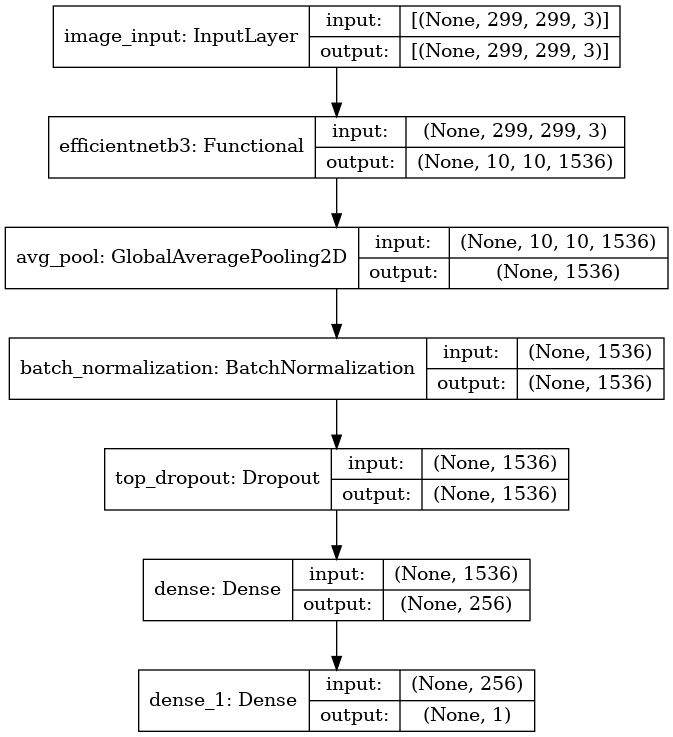

In [15]:
from keras.utils.vis_utils import plot_model
plot_model(model,show_shapes=True)

In [16]:
train_generator, validation_generator, test_generator = define_generators()

history = model.fit(
    train_generator,
    epochs=nb_epoch,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data= validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks = training_callbacks()
)

Found 1800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 0 images belonging to 1 classes.


2022-04-18 16:20:37.542164: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-04-18 16:20:52.009967: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


112/112 [==============================] - 122s 914ms/step - loss: 0.7491 - accuracy: 0.6693 - val_loss: 0.5651 - val_accuracy: 0.7292

Epoch 00001: accuracy improved from -inf to 0.66928, saving model to model.h5


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
112/112 [==============================] - 78s 698ms/step - loss: 0.6333 - accuracy: 0.7192 - val_loss: 0.4818 - val_accuracy: 0.7656

Epoch 00002: accuracy improved from 0.66928 to 0.71917, saving model to model.h5
Epoch 3/100
112/112 [==============================] - 79s 703ms/step - loss: 0.5529 - accuracy: 0.7534 - val_loss: 0.3455 - val_accuracy: 0.8438

Epoch 00003: accuracy improved from 0.71917 to 0.75336, saving model to model.h5
Epoch 4/100
112/112 [==============================] - 78s 692ms/step - loss: 0.4922 - accuracy: 0.7876 - val_loss: 0.4836 - val_accuracy: 0.7865

Epoch 00004: accuracy improved from 0.75336 to 0.78756, saving model to model.h5
Epoch 5/100
112/112 [==============================] - 78s 691ms/step - loss: 0.5093 - accuracy: 0.7881 - val_loss: 0.3414 - val_accuracy: 0.8490

Epoch 00005: accuracy improved from 0.78756 to 0.78812, saving model to model.h5
Epoch 6/100
112/112 [==============================] - 79s 700ms/step - loss: 0.4306 - a

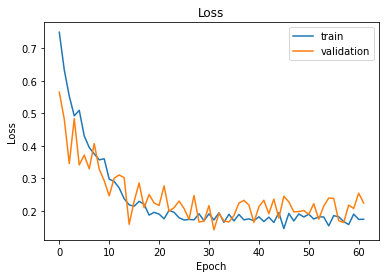

<Figure size 432x288 with 0 Axes>

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label = "validation")
plt.legend(loc='upper right')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Loss.png')

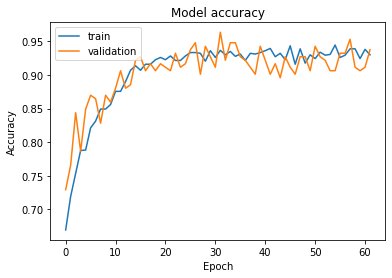

<Figure size 432x288 with 0 Axes>

In [18]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label = "validation")
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.savefig('Accuracy.png')

In [19]:
model.save_weights('binary_efficientnetB3.h5')

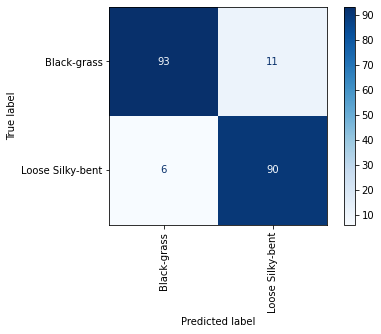

In [20]:
validation_generator.reset() 
val_pred = model.predict(validation_generator, steps=validation_generator.samples)
y_pred = val_pred>0.5
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Black-grass', 'Loose Silky-bent'])

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [21]:
# def create_main_classifier():
#     model_main = Xception(weights='imagenet', input_shape=(width, height, 3), include_top=False)
#     layer = model_main.output
#     layer = GlobalAveragePooling2D(name="avg_pool")(layer)
#     layer = BatchNormalization()(layer)
    
#     layer = Dropout(0.2, name="top_dropout")(layer)

#     dropout_1 = tf.keras.layers.Dropout(0.2)(layer)
#     model_dense2 = tf.keras.layers.Dense(256, activation = 'selu', activity_regularizer=tf.keras.regularizers.l2(1e-5))(dropout_1)
#     dropout_2 = tf.keras.layers.Dropout(0.2)(model_dense2)
#     model_dense3 = tf.keras.layers.Dense(128, activation='selu')(dropout_2)
#     model_out = tf.keras.layers.Dense(12, activation="softmax")(model_dense3)

#     model = tf.keras.models.Model(model_main.input,  model_out)
#     optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
#     model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
#     return model

In [22]:
# xception = create_main_classifier()
# xception.summary()
# xception.load_weights(f'{model_dir}xception_new.h5')

In [23]:
# predictions = xception.predict(test_generator, steps=test_generator.samples)

# class_list = []

# for i in range(0, predictions.shape[0]):
#     y_class = predictions[i, :].argmax(axis=-1)
#     class_list += [species_list[y_class]]

# submission = pd.DataFrame()
# submission['file'] = test_generator.filenames
# submission['file'] = submission['file'].str.replace(r'seg_test/', '')
# submission['species'] = class_list

In [24]:
# predictions = model.predict(test_generator, steps=test_generator.samples)

# class_list = []

# for i in range(0, predictions.shape[0]):
#     y_class = (predictions[i, :]>0.5).astype('int32')[0]
#     class_list += [binary_list[y_class]]

# binary = pd.DataFrame()
# binary['file'] = test_generator.filenames
# binary['file'] = binary['file'].str.replace(r'seg_test/', '')
# binary['species'] = class_list

In [25]:
# for idx, pred in enumerate(submission['species']):
#     if pred == 'Black-grass' or pred == 'Loose Silky-bent':
#         print(f'Modifying Sumission {submission["species"][idx]} to {binary["species"][idx]}')
#         submission['species'][idx] = binary['species'][idx]

In [26]:
# submission.to_csv('xception_binary.csv', index=False)
# print('Submission file generated. All done.')